In [2]:
%load_ext autoreload
%autoreload 2

In [2]:
from tqdm import tqdm
import numpy as np 
from scipy.stats import norm, qmc
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import sys
sys.path.append("..")
from src.py.option import AsianOption
from src.py.tasmanian_tools import make_grid

In [3]:
s_0_l=80.0
s_0_r=120.0
sigma_l=0.1
sigma_r=0.2
mu_l=0.02
mu_r=0.05
T_l=0.9
T_r=1.0
K_l=109.0
K_r=110.0

In [4]:
# max possible dim, level before 16 GB RAM is full: 40, 4
dim = 16
aop = AsianOption(d=dim)
level = 4
lb, rb = np.zeros(dim), np.ones(dim)

grid = make_grid(dim, level, lb, rb, "gauss-patterson")
weights, points = grid.getQuadratureWeights(), grid.getPoints()
pre_factor = np.exp(-aop.r*aop.T+aop.M)
payout_v = aop.payout_func_opt(points)
pre_factor*np.inner(weights, payout_v), aop.scholes_call()

(7.152087238522643, 7.15590176686306)

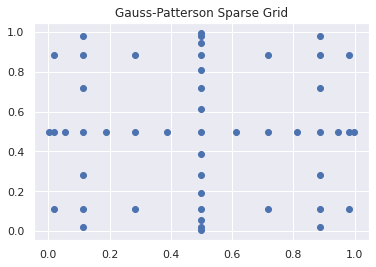

In [48]:
grid2d = make_grid(2, 3, np.zeros(2), np.ones(2), "gauss-patterson")
weights2d, points2d = grid2d.getQuadratureWeights(), grid2d.getPoints()
plt.scatter(points2d[:, 0], points2d[:, 1])
plt.title("Gauss-Patterson Sparse Grid")
plt.savefig("Gauss_patterson_sg.PNG")


In [47]:
points2d.shape

(49, 2)

In [7]:
bop = AsianOption(d=dim, random_walk=True)
rwalk = bop.gamma_d
bop = AsianOption(d=dim)
pca = bop.gamma_d

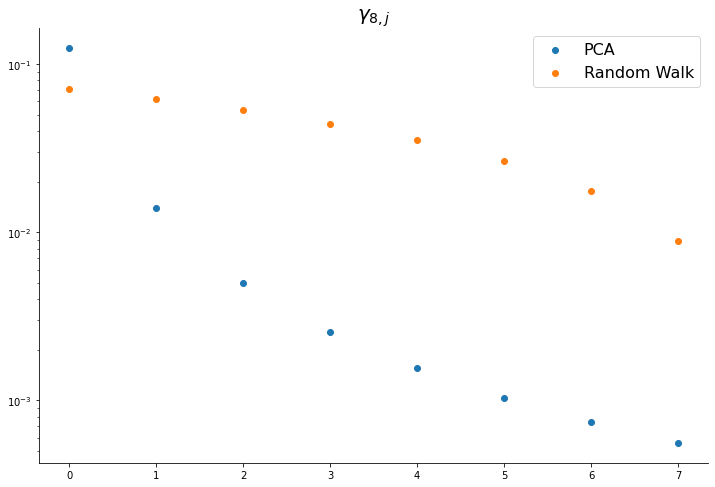

In [8]:
plt.figure(figsize=(12,8))
plt.scatter(np.arange(dim), pca)
plt.scatter(np.arange(dim), rwalk)
sns.despine()
plt.yscale("log")
plt.legend(["PCA", "Random Walk"], fontsize=16)
plt.title("$\gamma_{8,j}$", fontsize=20)
#plt.savefig("gamma_dj.PNG")
plt.show()

In [6]:
s_0 = np.linspace(s_0_l, s_0_r, 21)
sigma = np.linspace(sigma_l, sigma_r, 5)
mu = np.linspace(mu_l, mu_r, 9)
T = np.linspace(T_l, T_r, 9)
K = np.linspace(K_l, K_r, 9)

mesh = np.meshgrid(s_0, sigma, mu, T, K)
grid_ar = np.stack(mesh, -1).reshape(-1, 5)

## vectorizing training data generation takes up too much memory
# -> make a loop

#for s_0, sigma, mu, T, K in grid_ar[:10]:
#    print(s_0, sigma, mu, T, K)
grid_ar.shape

In [ ]:
#grid_ar.shape[0]
Y = np.empty((grid_ar.shape[0], 2), dtype=np.float64)
i = 0
for s_0, sigma, mu, T, K in grid_ar[:]:
    aop = AsianOption(S_0=s_0, sigma=sigma, r=mu, T=T, K=K, d=dim)
    pre_factor = np.exp(-aop.r*aop.T+aop.M)
    payout_v = aop.payout_func_opt(points)
    Y[i] = pre_factor*np.inner(weights, payout_v), aop.scholes_call()
    i=+1

In [ ]:
ar = np.load("sparse_geom_asian_out.npy")

In [ ]:
#plt.scatter(range(10), np.abs(np.diff(ar[990:1000])))
print(grid_ar[999])
op = AsianOption(
    S_0=grid_ar[999, 0],
    sigma=grid_ar[999, 1],
    r=grid_ar[999, 2], T=grid_ar[999, 3], K=grid_ar[999, 4], d=dim)
op.scholes_call()

[8.200e+01 1.000e-01 3.125e-02 9.375e-01 1.090e+02]


4.1200089200465264e-07

In [34]:
dim = 16
aop = AsianOption(d=dim)
level = 4
lb, rb = np.zeros(dim), np.ones(dim)

grid = make_grid(dim, level, lb, rb, "gauss-patterson")
weights, points = grid.getQuadratureWeights(), grid.getPoints()


In [36]:
points = points.astype(np.float32)
points.nbytes/1e6

798.720192

In [17]:
err_ar = list()
dim = 16
aop = AsianOption(d=dim)
level = 2
lb, rb = np.zeros(dim), np.ones(dim)

for l in range(2, 8):
    grid = make_grid(dim, l, lb, rb, "gauss-patterson")
    weights, points = grid.getQuadratureWeights(), grid.getPoints()
    pre_factor = np.exp(-aop.r*aop.T+aop.M)
    payout_v = aop.payout_func_opt(points)
    v_hat, v = pre_factor*np.inner(weights, payout_v), aop.scholes_call()
    err_ar.append([len(points), np.log10(np.abs(v-v_hat))])

In [44]:
err_ar = list()
dim = 16
aop = AsianOption(d=dim, K=0.01, S_0=0.1)
level = 2
lb, rb = np.zeros(dim), np.ones(dim)

for l in range(2, 7):
    grid = make_grid(dim, l, lb, rb, "gauss-patterson")
    weights, points = grid.getQuadratureWeights(), grid.getPoints()
    pre_factor = np.exp(-aop.r*aop.T+aop.M)
    payout_v = aop.payout_func_opt(points)
    v_hat, v = pre_factor*np.inner(weights, payout_v), aop.scholes_call()
    print(len(points), np.log10(np.abs(v-v_hat)))

577 -4.686933128452411
7105 -5.540079893238052
69121 -6.5613665959582335
565249 -7.034743481233656
4038145 -6.844131637930671


In [45]:
qmc_sampler = qmc.Sobol(
    d=dim,
    seed=69
)
#n_samples = 
for n_samples in [2**9, 2**13, 2**16,2**19, 2**22]:
    samples = qmc_sampler.random(n_samples)
    payout_mc = aop.payout_func_opt(samples)
    v_mc = pre_factor*np.sum(payout_mc)/n_samples
    print(np.log10(np.abs(v_mc-v)))

-5.218424473320633
-5.968979969108424
-7.396726533088685
-6.80017963708574
inf


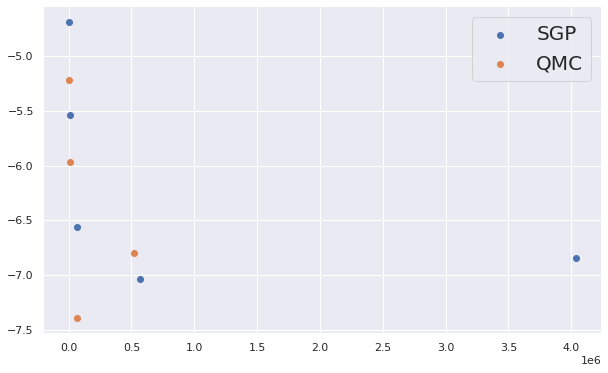

In [41]:
sg_errors = np.array([[577, -4.686933128452411],
[7105, -5.540079893238052],
[69121, -6.5613665959582335],
[565249, -7.034743481233656],
[4038145, -6.844131637930671]])
mc_errors = np.array([[2**9,-5.218424473320633],
[2**13, -5.968979969108424],
[2**16,-7.396726533088685],
[2**19, -6.80017963708574],
[2**22, np.inf]])

plt.style.use("seaborn-colorblind")
sns.set_theme()

plt.figure(figsize=(10,6))
plt.scatter(x=sg_errors[:, 0], y=sg_errors[:, 1])
plt.scatter(x=mc_errors[:, 0], y=mc_errors[:, 1])
plt.legend(["SGP", "QMC"], fontsize=20)
sns.despine()
plt.savefig("sgmc_errors.PNG")

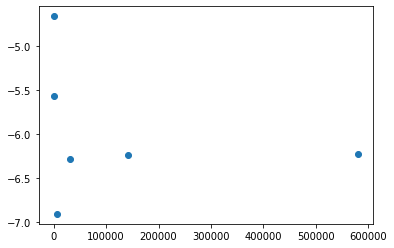

In [30]:
plt.scatter(np.array(err_ar)[:, 0],np.array(err_ar)[:, 1])
